In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


folder = "datas/"
gestures = {1: "Stop sign", 2: "Thumbs down", 3: "Waving", 4: "Pointing",
            5: "Calling someone", 6: "Thumbs up", 7: "Wave someone away",9: "Others"}#, 0: "Nodding",  8: "Shaking head"}
gestures_len = 8
sequence_len = 10
size = (64,64)

def rolling_window2D(a,n,step=3):
    # a: 2D Input array 
    # n: Group/sliding window length
    return a[np.arange(a.shape[0]-n+1)[:,None] + np.arange(n)][::step, :]

def load_csv(Xd, Yd, sequence_len = 30):
    X=[]
    Y=[]
    for x1, y1 in zip(Xd, Yd):
        try:
            frames = []
            cap = cv2.VideoCapture(x1)
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                  cap.release()
                  cv2.destroyAllWindows()
                  break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = cv2.resize(frame, size) 
                frame = frame/255
                frames.append(frame)
            frames = np.array(frames)
            x = rolling_window2D(frames,sequence_len)
            X.extend(list(x))
            y = np.ones(len(x),dtype=int)*y1
            #y = np.ones(len(x),dtype=int)*i
            Y.extend(list(y))
        except Exception as e:
            print(e)
            pass # Exception as e
    return np.array(X),np.array(Y)

Xd=[]
Yd=[]
folder_list = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]
for folder_i in folder_list:
    for i, k in enumerate(list(gestures.keys())):
        dir_list = os.listdir(folder+folder_i+"/gesture/"+str(k))
        for d in dir_list:
            if d!="desktop.ini":
                Xd.append(folder+folder_i+"/gesture/"+str(k)+"/"+d)   
                Yd.append(i)
X_train, X_test, y_train, y_test = train_test_split(Xd, Yd, test_size=0.2, random_state=42, stratify=Yd)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X_train,y_train = load_csv(X_train,y_train,sequence_len)
X_test,y_test = load_csv(X_test,y_test,sequence_len)
X_val,y_val = load_csv(X_val,y_val,sequence_len)

y_train = to_categorical(y_train).astype(int)
y_val = to_categorical(y_val).astype(int)
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

2023-06-23 20:50:31.086281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 20:50:31.460247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zany/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2023-06-23 20:50:31.460334: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-23 20:50:31.508027: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to reg

(3880, 10, 64, 64) (3880, 8)
(970, 10, 64, 64) (970, 8)
(1228, 10, 64, 64) (1228,)


model loaded
Epoch 1/20
485/485 [==============================] - 5s 9ms/step - loss: 1.1077 - categorical_accuracy: 0.5881 - val_loss: 7.8724 - val_categorical_accuracy: 0.1000
Epoch 2/20
485/485 [==============================] - 4s 8ms/step - loss: 0.3052 - categorical_accuracy: 0.9003 - val_loss: 9.9337 - val_categorical_accuracy: 0.1000
Epoch 3/20
485/485 [==============================] - 4s 8ms/step - loss: 0.1269 - categorical_accuracy: 0.9582 - val_loss: 12.1837 - val_categorical_accuracy: 0.1041
Epoch 4/20
485/485 [==============================] - 4s 8ms/step - loss: 0.0786 - categorical_accuracy: 0.9784 - val_loss: 11.4064 - val_categorical_accuracy: 0.1381
Epoch 5/20
485/485 [==============================] - 4s 8ms/step - loss: 0.0567 - categorical_accuracy: 0.9827 - val_loss: 12.3232 - val_categorical_accuracy: 0.1062
Epoch 6/20
485/485 [==============================] - 4s 8ms/step - loss: 0.0577 - categorical_accuracy: 0.9812 - val_loss: 13.2906 - val_categorical_accu

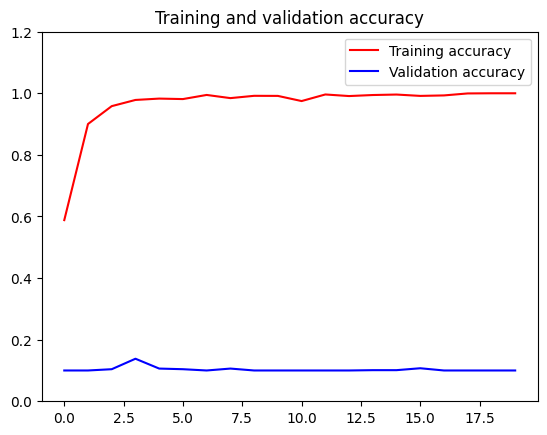

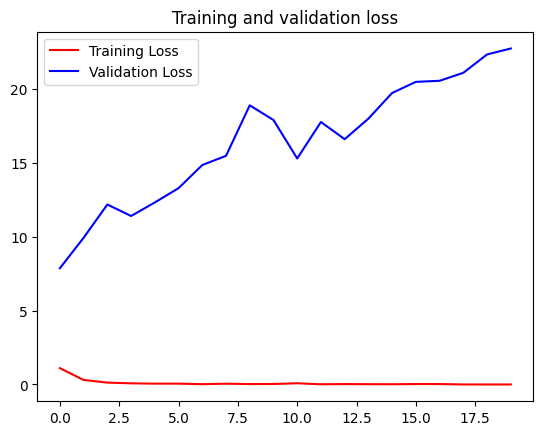

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model

def build_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(10, 64, 64)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(gestures), activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = build_model()
print("model loaded")

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=20)
model.save("video_classifier_model_simple3.h5")

model = load_model("video_classifier_model_simple2.h5")

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim([0,1.2])
plt.savefig('evaluation2__accuracy.png', dpi=300)
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
#plt.ylim([0,1])
plt.legend()
plt.savefig('evaluation2__loss.png', dpi=300)
plt.show()

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def build_model():    

    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape = (10, 64, 64)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(gestures), activation='softmax'))
    #model.summary() # to see the architecture
    #model.summary() # to see the architecture
    # Compiling the Model. 
    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
    return model



    

In [ ]:
# Train the model
# model = build_model()

model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=20)
model.s

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def build_model(): 
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, activation='relu'), input_shape=(10, 96, 96, 1)))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(Dense(64, activation='relu'))
    model.add(LSTM(100))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(len(gestures), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model
    

model = build_model()
# X_train = X_train.reshape(X_train.shape[0], 1, 10, 64, 64)
# X_val = X_val.reshape(X_val.shape[0], 1, 10, 64, 64)
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=10)
model.save("video_classifier_model.h5")


In [ ]:
# Evaluate the model
y_test_new = to_categorical(y_test,8)
print(y_test_new.shape)
pred = model.predict(X_test,8)
loss, accuracy = model.evaluate(X_test, y_test_new)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

39/39 [==============================] - 0s 5ms/step
## 20.28% accuracy on the test set
                   precision    recall  f1-score   support

  Calling someone       0.00      0.00      0.00       194
           Others       0.49      0.63      0.55       194
         Pointing       0.00      0.01      0.01        97
        Stop sign       0.00      0.00      0.00       161
      Thumbs down       1.00      0.50      0.67       194
        Thumbs up       0.00      0.00      0.00        97
Wave someone away       0.20      0.15      0.17       194
           Waving       0.00      0.00      0.00        97

         accuracy                           0.20      1228
        macro avg       0.21      0.16      0.17      1228
     weighted avg       0.27      0.20      0.22      1228



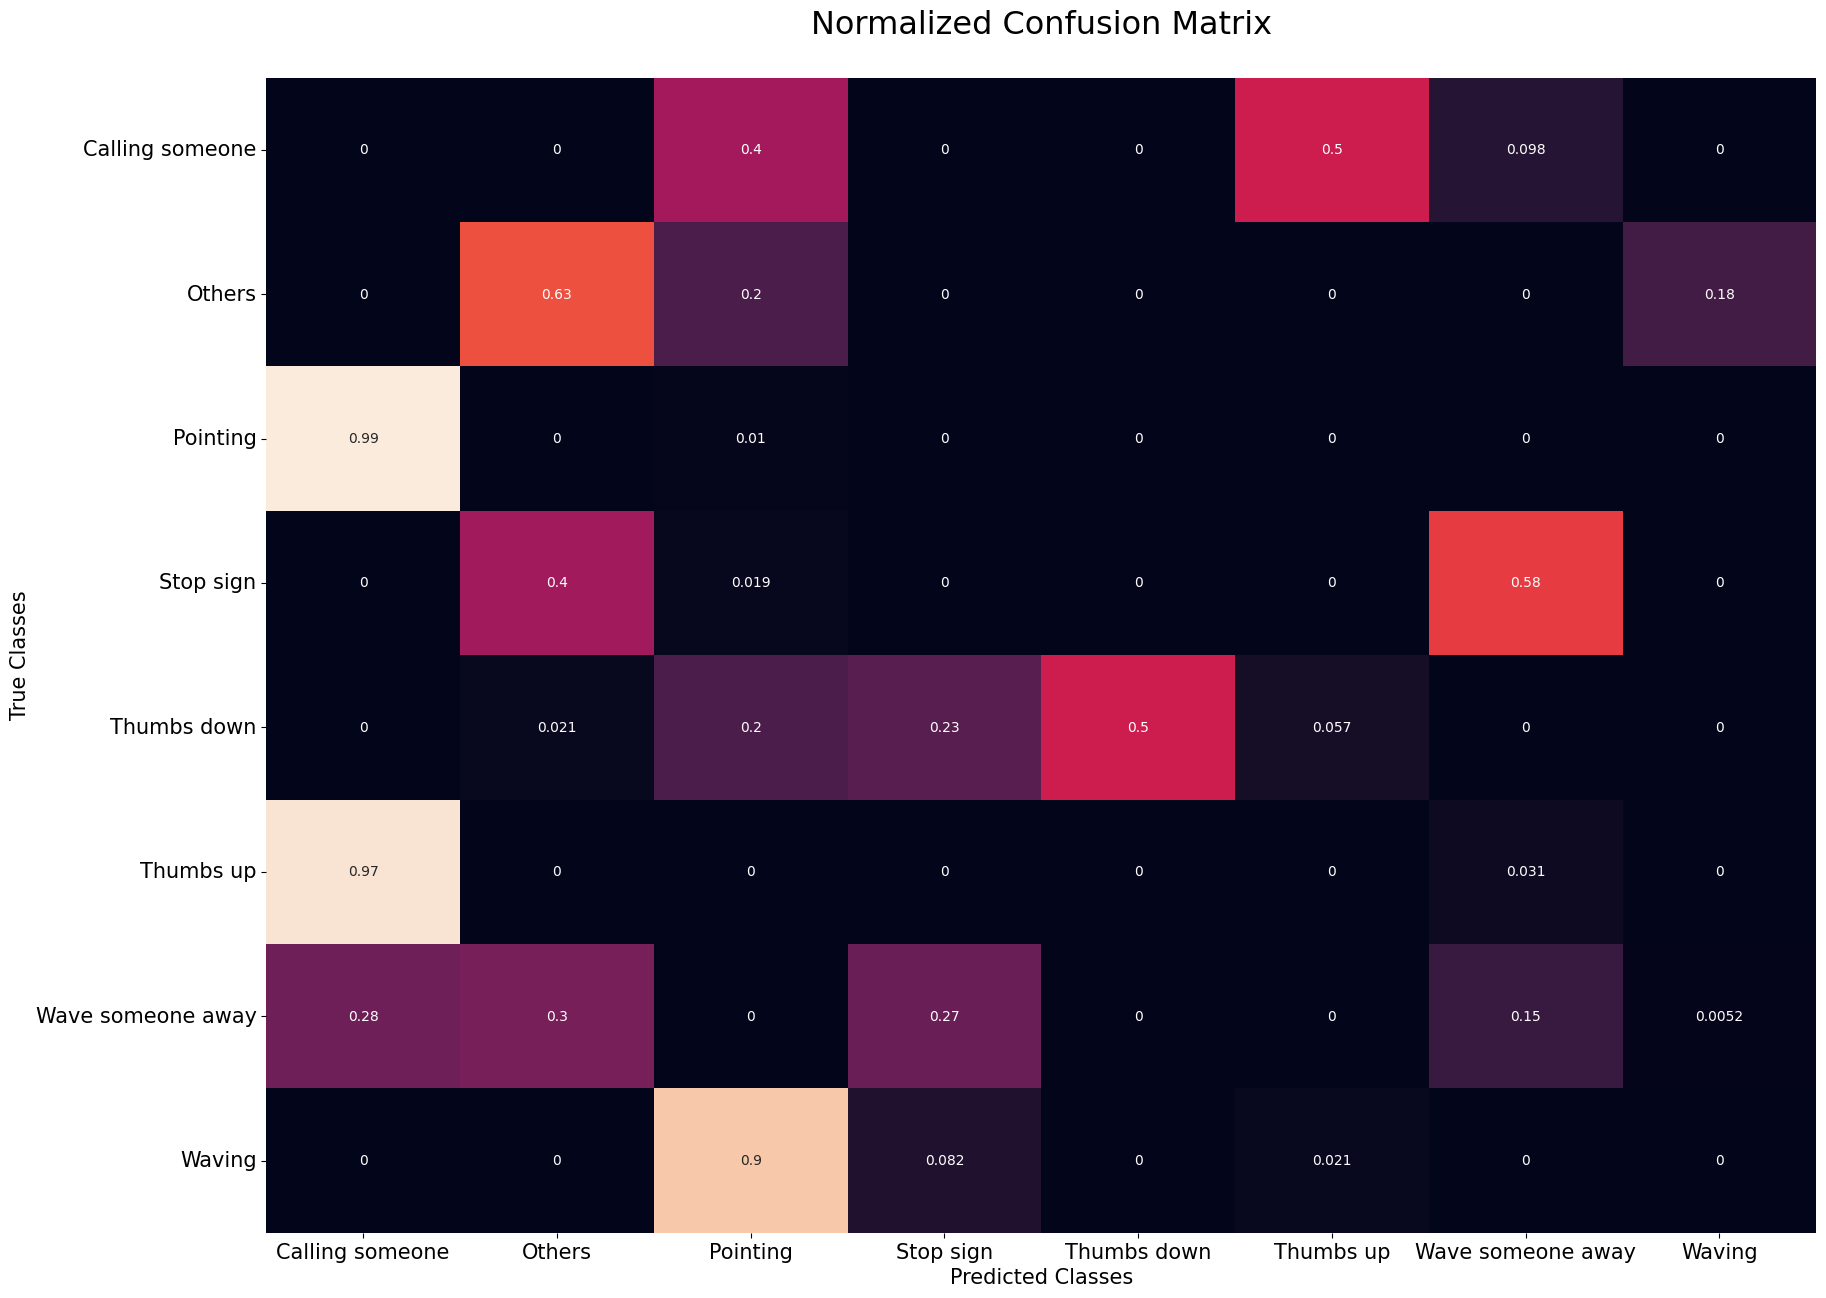

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model

model = load_model("video_classifier_model_simple3.h5")

pred = model.predict(X_test)
#pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
acc = accuracy_score(y_test,pred)

# Display the results
print(f'## {acc*100:.2f}% accuracy on the test set')

# Map the numbers into letters
y_test_letters = [gestures[list(gestures.keys())[x]] for x in y_test]
pred_letters = [gestures[list(gestures.keys())[x]] for x in pred]

print(classification_report(y_test_letters, pred_letters))

# Display a confusion matrix
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.savefig('evaluation2_Confusion_Matrix2.png', dpi=300)
plt.show()